<a href="https://colab.research.google.com/github/JuanOpizzi/IA-Spotify/blob/main/Analisis_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduccion
en este notebook se analizará, un dataset de 2000 canciones, y se espera crear una red neuronal capaz de poder el valor de popularidad de una canción

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras import models
from keras import layers
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import category_encoders as ce
import tensorflow as tf

In [ ]:
spotify = pd.read_csv('Spotify-2000.csv',
                      dtype={
                          'Top Genre':'category',
                          'Year':'category'},
                     decimal=",")
spotify.head()

,Index,Title,Artist,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,1,Sunrise,Norah Jones,adult standards,2004,157,30,53,-14,11,68,201.0,94,3,71
1,2,Black Night,Deep Purple,album rock,2000,135,79,50,-11,17,81,207.0,17,7,39
2,3,Clint Eastwood,Gorillaz,alternative hip hop,2001,168,69,66,-9,7,52,341.0,2,17,69
3,4,The Pretender,Foo Fighters,alternative metal,2007,173,96,43,-4,3,37,269.0,0,4,76
4,5,Waitin' On A Sunny Day,Bruce Springsteen,classic rock,2002,106,82,58,-5,10,87,256.0,1,3,59


In [ ]:
spotify.shape

(1994, 15)

#### Limpieza de datos

Eliminimo las columnas Index, Title (y Artist?) y que no son Features como tal 

In [ ]:
spotify_clean = spotify.drop(columns=['Index', 'Title', 'Artist'])
spotify_clean.mean()

Beats Per Minute (BPM)    120.215647
Energy                     59.679539
Danceability               53.238215
Loudness (dB)              -9.008526
Liveness                   19.012036
Valence                    49.408726
Length (Duration)         259.842122
Acousticness               28.858074
Speechiness                 4.994985
Popularity                 59.526580
dtype: float64

Normalizamos las variables

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

columnas_numericas = spotify_clean.select_dtypes(include=numerics).columns.to_list()

In [ ]:
maximo = spotify_clean['Popularity'].max()
minimo = spotify_clean['Popularity'].min()

In [ ]:
spotify_clean[columnas_numericas] = (spotify_clean[columnas_numericas] - spotify_clean[columnas_numericas].min()) / (spotify_clean[columnas_numericas].max() - spotify_clean[columnas_numericas].min())
spotify_clean.head()

,Top Genre,Year,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,adult standards,2004,0.710059,0.278351,0.500000,0.52,0.092784,0.677083,0.207154,0.949495,0.018868,0.674157
1,album rock,2000,0.579882,0.783505,0.465116,0.64,0.154639,0.812500,0.213373,0.171717,0.094340,0.314607
2,alternative hip hop,2001,0.775148,0.680412,0.651163,0.72,0.051546,0.510417,0.352250,0.020202,0.283019,0.651685
3,alternative metal,2007,0.804734,0.958763,0.383721,0.92,0.010309,0.354167,0.277630,0.000000,0.037736,0.730337
4,classic rock,2002,0.408284,0.814433,0.558140,0.88,0.082474,0.875000,0.264156,0.010101,0.018868,0.539326


Ahora convierto la columna de Generos, de variable categorica (Top Genre y Year) a numerica, usando binary encoding

In [ ]:
encoder = ce.BinaryEncoder(cols=['Top Genre', 'Year'],return_df=True)
spotify_clean = encoder.fit_transform(spotify_clean) 
spotify_clean.head()

/home/juan/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Top Genre_0,Top Genre_1,Top Genre_2,Top Genre_3,Top Genre_4,Top Genre_5,Top Genre_6,Top Genre_7,Top Genre_8,Year_0,...,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness,Popularity
0,0,0,0,0,0,0,0,0,1,0,...,0.710059,0.278351,0.500000,0.52,0.092784,0.677083,0.207154,0.949495,0.018868,0.674157
1,0,0,0,0,0,0,0,1,0,0,...,0.579882,0.783505,0.465116,0.64,0.154639,0.812500,0.213373,0.171717,0.094340,0.314607
2,0,0,0,0,0,0,0,1,1,0,...,0.775148,0.680412,0.651163,0.72,0.051546,0.510417,0.352250,0.020202,0.283019,0.651685
3,0,0,0,0,0,0,1,0,0,0,...,0.804734,0.958763,0.383721,0.92,0.010309,0.354167,0.277630,0.000000,0.037736,0.730337
4,0,0,0,0,0,0,1,0,1,0,...,0.408284,0.814433,0.558140,0.88,0.082474,0.875000,0.264156,0.010101,0.018868,0.539326


Separo el dataset, por un lado 'X' va a tener de columnas todos los posibles features que se puede user, 'y' va a ser nuestra columna target, el valor que queremos predecir

In [ ]:
X, y = spotify_clean.iloc[:,:-1], spotify_clean.iloc[:,-1]

In [ ]:
n_features = X.columns.size

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [ ]:
def generadorRed(n_nuronas=32, n_capas_intermedias=4, lr=0.2):
    
    red = models.Sequential()

    red.add(layers.Dense(units=n_nuronas, activation='relu', input_shape=(n_features, )))

    for _ in range(n_capas_intermedias):
        red.add(layers.Dense(units=n_nuronas, activation='relu'))


    red.add(layers.Dense(units=1, activation='sigmoid'))

    # Compile neural network
    red.compile(loss='mean_absolute_error',  # Mean Error
                optimizer=SGD(lr=lr),  # Stocastic Gradiend Descent
                metrics=['mse'])  # Accuracy performance metric
    return red

# Random search


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

learning_rate = [0.1, 0.2, 0.4, 0.7]
cantidad_neuronas = [4, 8, 16, 32]
cantidad_capas = [1, 2, 4, 8, 16]
scoreTotal = []
cantidad_folds = 5
cantidad_batch = 1

# lr => learning rate
# n_nuronas => cantidad de neuronas
# n_capas_intermedias => cantidad de capas

params = {'lr': [0.1, 0.2, 0.4, 0.7],\
          'n_nuronas': [4, 8, 16, 32],\
         'n_capas_intermedias': [1, 2, 4, 8, 16] }
red_neuronal = KerasRegressor(build_fn=generadorRed,
                              epochs=2000,
                              batch_size=X_train.shape[0],
                              verbose=0
                            )

rgscv = RandomizedSearchCV(
    red_neuronal,
    params, n_iter=60, scoring='neg_mean_squared_error', 
    cv=cantidad_folds, return_train_score=True
).fit(X_train, y_train)

In [ ]:
print(f"Best score: {rgscv.best_score_}")
print(f"Best params {rgscv.best_params_}")

Best score: -0.021458875015378
Best params {'n_nuronas': 32, 'n_capas_intermedias': 1, 'lr': 0.1}


In [ ]:
# Harcodeo mejores hiperparametros en una variable porque el random search me consume 
# demasiado CPU y genera mucho calor, este es el resultado de un random search

best_neuronas = 32
best_capas = 1
best_lr = 0.1

Vamos a guardar el .fit del modelo en una variable para después plotear el aprendizaje. Podemos pasar como parámetros el set de validación para ir evaluando en cada paso del entrenamiento, además de evaluar el de entrenamiento. Podemos cambiar la cantidad de información que nos muestra con verbose y además tenemos que decirle la cantidad de épocas que queremos entrenar.

In [ ]:
hist = red_neuronal.fit(X_train, y_train,epochs=200,
        verbose=2, validation_data=(X_test, np.array(y_test)),)

Epoch 1/200
1/1 - 1s - loss: 0.1423 - mse: 0.0287 - val_loss: 0.1397 - val_mse: 0.0276
Epoch 2/200
1/1 - 0s - loss: 0.1399 - mse: 0.0279 - val_loss: 0.1370 - val_mse: 0.0267
Epoch 3/200
1/1 - 0s - loss: 0.1379 - mse: 0.0273 - val_loss: 0.1348 - val_mse: 0.0260
Epoch 4/200
1/1 - 0s - loss: 0.1365 - mse: 0.0269 - val_loss: 0.1331 - val_mse: 0.0256
Epoch 5/200
1/1 - 0s - loss: 0.1353 - mse: 0.0266 - val_loss: 0.1317 - val_mse: 0.0252
Epoch 6/200
1/1 - 0s - loss: 0.1344 - mse: 0.0265 - val_loss: 0.1306 - val_mse: 0.0249
Epoch 7/200
1/1 - 0s - loss: 0.1338 - mse: 0.0263 - val_loss: 0.1297 - val_mse: 0.0247
Epoch 8/200
1/1 - 0s - loss: 0.1333 - mse: 0.0263 - val_loss: 0.1289 - val_mse: 0.0246
Epoch 9/200
1/1 - 0s - loss: 0.1329 - mse: 0.0262 - val_loss: 0.1283 - val_mse: 0.0244
Epoch 10/200
1/1 - 0s - loss: 0.1326 - mse: 0.0262 - val_loss: 0.1278 - val_mse: 0.0243
Epoch 11/200
1/1 - 0s - loss: 0.1323 - mse: 0.0262 - val_loss: 0.1274 - val_mse: 0.0243
Epoch 12/200
1/1 - 0s - loss: 0.1322 - ms

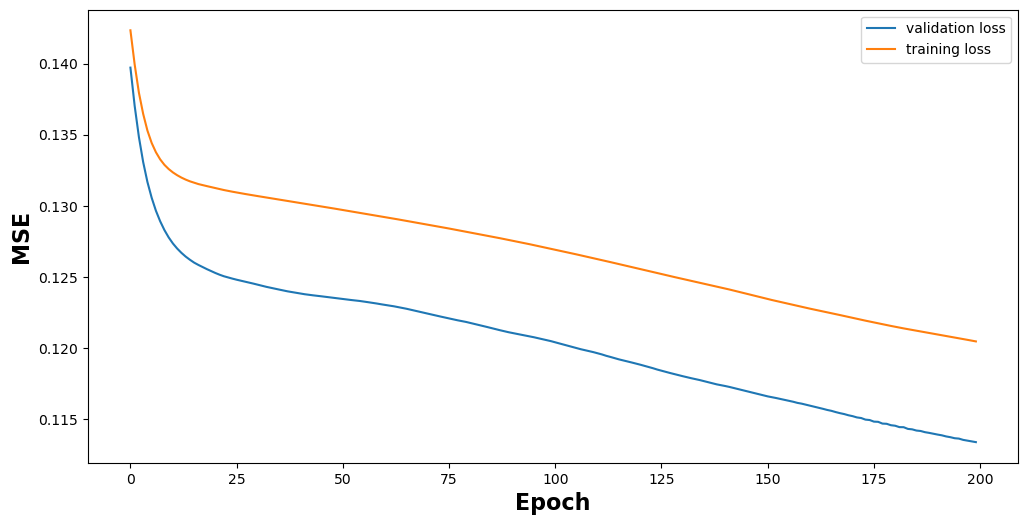

In [ ]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(hist.history["val_loss"], label="validation loss")
plt.plot(hist.history["loss"], label="training loss")
plt.xlabel("Epoch", weight="bold", fontsize=16)
plt.ylabel("MSE", weight="bold", fontsize=16)
plt.legend()

Los valores predecidos nos dan entre 0 y 1, asi que los desnormalizo

In [ ]:
y_pred = red_neuronal.predict(X_test)

In [ ]:
y_pred = y_pred * (maximo - minimo) + minimo

In [ ]:
y_lista = (y_test * (maximo - minimo) + minimo).to_list()

In [ ]:
np.mean((y_pred - y_lista)**2)

147.0205640235143

In [ ]:
y_test.size

399

In [ ]:
y_pred[4]

43.954197

In [ ]:
y_lista[4]

57.00000000000001

## Precision

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
X_test

,Top Genre_0,Top Genre_1,Top Genre_2,Top Genre_3,Top Genre_4,Top Genre_5,Top Genre_6,Top Genre_7,Top Genre_8,Year_0,...,Year_6,Beats Per Minute (BPM),Energy,Danceability,Loudness (dB),Liveness,Valence,Length (Duration),Acousticness,Speechiness
1899,0,0,0,0,0,0,0,1,0,0,...,0,0.254438,0.484536,0.465116,0.64,0.185567,0.322917,0.207154,0.353535,0.056604
988,0,0,1,1,1,1,1,0,0,0,...,0,0.538462,0.474227,0.325581,0.72,0.391753,0.177083,0.290066,0.222222,0.018868
1264,0,0,1,1,1,1,0,1,1,0,...,0,0.514793,0.443299,0.965116,0.72,0.041237,0.760417,0.264156,0.141414,0.547170
1029,0,0,0,0,0,0,0,0,1,0,...,1,0.609467,0.402062,0.255814,0.64,0.082474,0.270833,0.210264,0.555556,0.018868
1599,0,1,0,0,0,1,0,1,1,0,...,1,0.514793,0.639175,0.767442,0.48,0.072165,0.864583,0.342923,0.212121,0.018868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,0,0,1,1,0,0,0,0,1,0,...,0,0.520710,0.876289,0.581395,0.84,0.092784,0.572917,0.483873,0.000000,0.037736
558,0,0,1,0,1,1,0,1,0,0,...,0,0.573964,0.917526,0.569767,0.88,0.257732,0.625000,0.248610,0.060606,0.075472
809,0,0,0,0,0,0,0,1,0,0,...,1,0.449704,0.927835,0.534884,0.68,0.340206,0.614583,0.150153,0.010101,0.075472
210,0,0,0,0,1,0,0,0,0,0,...,1,0.786982,0.525773,0.476744,0.80,0.072165,0.260417,0.248610,0.313131,0.037736


In [ ]:
precision_score(y_lista, red_neuronal.predict(X_test))

ValueError: continuous is not supported

# Busqueda de hiperparametros por fuerza bruta

In [ ]:
# Para el cross validation

red_neuronal_2 = lambda n, ci, lr: KerasRegressor(build_fn=generadorRed,
                              epochs=2000,
                              batch_size=X_train.shape[0],
                              n_nuronas=n,
                              n_capas_intermedias=ci,
                              lr=lr,
                              verbose=0
                            )

In [ ]:
## Crossvalidarion si es que queremos implementarlo mas adelante
# implemendanto gridSearch
learning_rate = [0.1, 0.2, 0.4, 0.7]
cantidad_neuronas = [4, 8, 16, 32]
cantidad_capas = [1, 2, 4, 8, 16]
scoreTotal = []
cantidad_folds = 5
cantidad_batch = 1
for lr in learning_rate:
    for neuronas in cantidad_neuronas:
        for capas in cantidad_capas:
            score = cross_val_score(red_neuronal_2(neuronas, capas, lr),
                                    X_train,
                                    y_train,
                                    cv=cantidad_folds,
                                    scoring='neg_mean_squared_error')

    # score = cross_val_score(red_neuronal_2, X_train, y_train, cv=5)
            print('----------------------------------')
            print('score:', score.mean())
            print('----------------------------------')
            scoreTotal.append(score.mean())

----------------------------------
score: -0.024749750271439552
----------------------------------
----------------------------------
score: -0.025406833738088608
----------------------------------
----------------------------------
score: -0.02636408880352974
----------------------------------
----------------------------------
score: -0.02678634077310562
----------------------------------
----------------------------------
score: -0.0267599418759346
----------------------------------
----------------------------------
score: -0.024729691073298456
----------------------------------
----------------------------------
score: -0.023949452862143516
----------------------------------
----------------------------------
score: -0.025096890702843665
----------------------------------
----------------------------------
score: -0.026201850548386574
----------------------------------
----------------------------------
score: -0.026786497980356216
----------------------------------
--------------

KeyboardInterrupt: 

In [ ]:
scoreTotal

In [ ]:
hist = red_neuronal.fit(X_train, y_train)

Los valores predecidos nos dan entre 0 y 1, asi que los desnormalizo

In [ ]:
y_pred = red_neuronal.predict(X_test)

In [ ]:
y_pred = y_pred * (maximo - minimo) + minimo


In [ ]:
y_lista = (y_test * (maximo - minimo) + minimo).to_list()


In [ ]:
np.mean((y_pred - y_lista)**2)

129.7852152188904

In [ ]:
y_test.size

399

In [ ]:
y_pred[4]

43.515118

In [ ]:
y_lista[4]

57.00000000000001

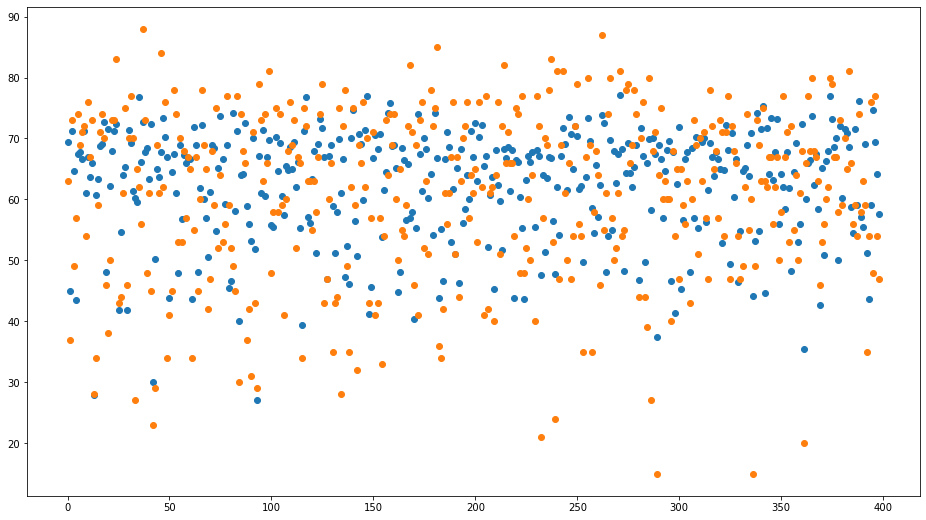

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=[16,9])
t = np.arange(len(y_pred))
plt.scatter(t, y_pred)
plt.scatter(t, y_lista)


plt.show()

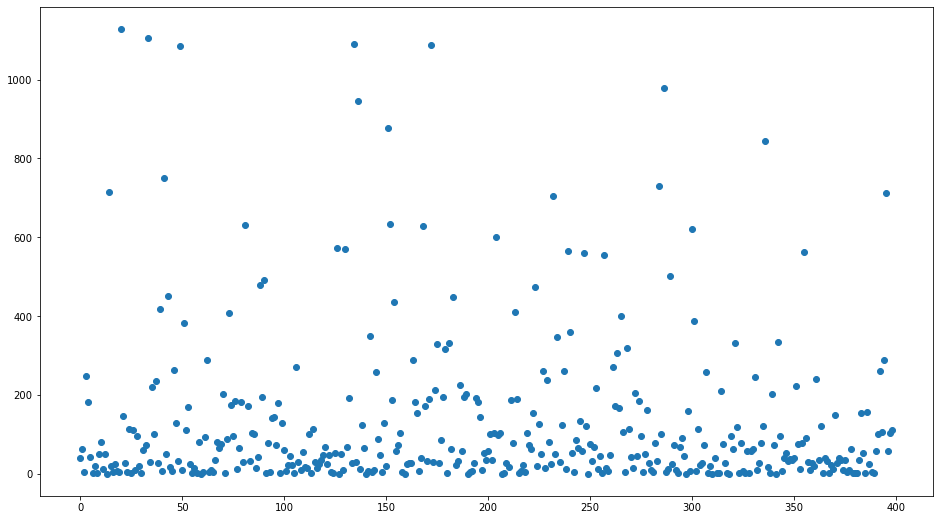

In [ ]:
plt.figure(figsize=[16,9])
plt.scatter(t, (y_pred - y_lista)**2)
plt.show()

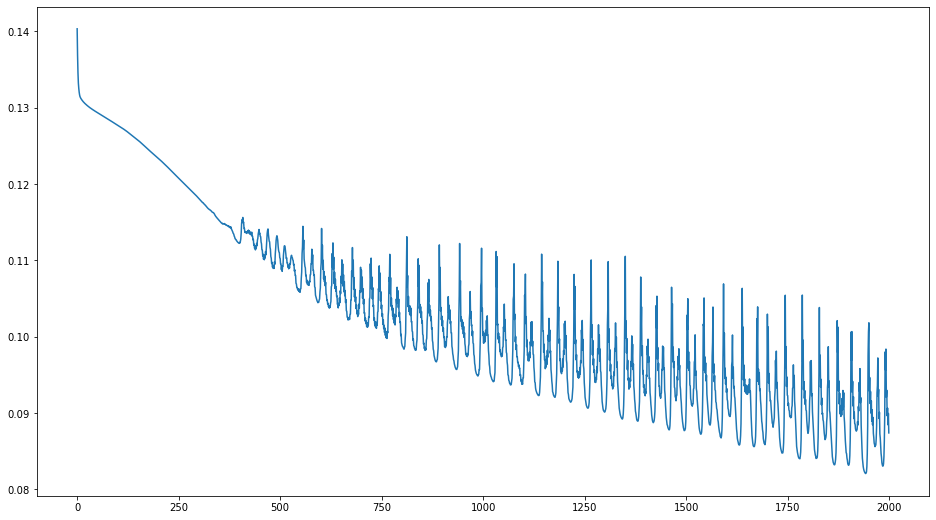

In [ ]:
loss = hist.history['loss']
plt.figure(figsize=[16,9])
plt.plot(np.arange(len(loss)), loss)
plt.show()